# A graduating statistician at the Particle Physics Playground - Part III

## Activity 03: reconstructing top quarks from jets
(The relevant Jupyter notebook can be dowloaded from this link: https://drive.google.com/file/d/1OmzOOn_m9K_HPuNaHnA9Jd0cXtWpFsqb/view)

In this final activity, I am required to reconstruct top quarks from jets and, to do this, I shall follow the same approach adopted for Activity 02 in Part II. 

I will first perform the analysis on MC simulated data, then on real data from the CMS experiment. This is pretty large in size, as it comprises almost half million collisions. Due to the large number of observations, I shall apply the functions **get_min_particles**, **get_combinations** and **get_parent_attributes** only to the first one-hundred thousand observations (in an attempt to do this on the whole dataset, the list of selected collisions was not obtained even after one hour and half!). It will be interesting to see functions in action with particles whose charge is defined by *np.nan*. As a final step, I will plot the masses resulting from the two reconstruction processes using superimposed histograms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pps_tools as pps
import pandas as pd
import os
path = 'C:\\Users\\ICON\\Desktop\\Python projects\\Particle Physics Playground\\playground-master\\data'
os.chdir(path)
%matplotlib notebook

C:\Users\ICON\anaconda3\lib\site-packages\h5hep-0.9-py3.8.egg\h5hep\write.py:423: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\ICON\anaconda3\lib\site-packages\h5hep-0.9-py3.8.egg\h5hep\write.py:423: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [2]:
def get_min_particles(collisions_list, particles, charge, min_num):
    """It first checks 'collisions_list' to search for collisions that generated fewer particles of the specified kind and 
    charge than required, giving an appropriate output message. If this is the case, it creates a new list containing only 
    the collisions where the minimum required number of those particles was generated. The argument 'particles' is a list 
    of the particle types involved in the decay mode (each type must be specified as a string such as 'pions' and, if it 
    appears in the decay mode with different charges, the string must be repeated once for each charge type). The argument
    'charge' is the list of the charges corresponding to the particles specified in the 'particles' argument (to be 
    specified either as -1, 0, 1 or np.nan if the particle has no charge, like for jets). The argument 'min_num' is the
    list of the number of times each charged particle appears in the decay mode. The function works on a deep copy of the 
    original list."""
    tuples = list(zip(particles,charge,min_num))
    from copy import deepcopy
    collisions_list_copy = deepcopy(collisions_list)
    all_indices_collisions_with_fewer_particles = []
    for index,tupl in enumerate(tuples):
        particles = tupl[0]
        charge = tupl[1]
        min_num = tupl[2]
        indices_collisions_with_fewer_particles = []
        for index,collision in enumerate(collisions_list_copy):
            all_particles = collision[particles]
            if (np.isnan(charge) == True and len(all_particles) < min_num):                
                indices_collisions_with_fewer_particles.append(index)
            elif np.isnan(charge) == False: 
                count_correctly_charged_particles = sum(map(lambda particle : particle['q'] == charge, all_particles))
                if count_correctly_charged_particles < min_num:
                    indices_collisions_with_fewer_particles.append(index)
        all_indices_collisions_with_fewer_particles.append(indices_collisions_with_fewer_particles)
    all_indices_flattened_list = [item for sublist in all_indices_collisions_with_fewer_particles for item in sublist]
    unique_indices_list = list(set(all_indices_flattened_list))
    if len(unique_indices_list) == 0:
        print('There are no collisions where the number of particles of some kind and charge is less than required.')
    else: 
        print('There are ' + str(len(unique_indices_list)) + ' collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.')
    collisions_list_new = []
    for index,collision in enumerate(collisions_list_copy):
        if index not in unique_indices_list: collisions_list_new.append(collision)
    if len(collisions_list_new) == len(collisions_list_copy) - len(unique_indices_list):
            print('The selection process terminated and the new list was created. It contains '
              + str(len(collisions_list_new)) + ' decay processes/collisions of ' 
              + str(len(collisions_list_copy)) + ' in the original list, following the removal of '
                  + str(len(unique_indices_list)) + ' elements.')
    else: print('An error occurred.')
    return collisions_list_new

In [3]:
def get_combinations(collisions_list,particles,charge,num):
    """It creates, for each collision selected by 'get_min_particles', all possible combinations of the particles specified 
    by the decay mode. The argument 'particles' is a list of the particle types involved in the decay mode (each type must 
    be specified as a string such as 'pions' and, if it appears in the decay mode with different charges, the string must be 
    repeated once for each charge type). The argument 'charge' is the list of the charges corresponding to the particles 
    specified in the 'particles' argument (to be specified either as -1, 0, 1 or np.nan if the particle has no charge, like 
    for jets). The argument 'num' is the list of the number of times each charged particle appears in the decay mode. It 
    returns a list of lists, where each sublist contains one combination of particles. In each sublist, the type of the 
    original particles is not referenced."""
    tuples = list(zip(particles,charge,num))
    from itertools import combinations, product
    decay_combinations = []
    for collision in collisions_list:   
        all_combinations = []
        for index,tupl in enumerate(tuples):
            particles = tupl[0]
            charge = tupl[1]
            num = tupl[2]
            all_particles = []
            for particle in collision[particles]:
                if np.isnan(charge) == True:
                    all_particles.append(particle)
                else: 
                    if particle['q'] == charge:
                        all_particles.append(particle)
            particle_combinations = list(combinations(all_particles, num))
            all_combinations.append(particle_combinations)
        decay_combinations_per_collision = list(product(*all_combinations))
        decay_combinations.append(decay_combinations_per_collision)
    flattened_decay_combinations = [item for sublist in decay_combinations for item in sublist]
    decay_combinations_final = []
    for tup in flattened_decay_combinations:
        single_combination = [item for subtuple in tup for item in subtuple]
        decay_combinations_final.append(single_combination)
    print('All possible combinations have been formed and the new list was created. It contains ' +
         str(len(decay_combinations_final)) + ' combinations.')
    return decay_combinations_final

In [4]:
def get_parent_attributes(decay_combinations_list):
    '''It computes the mass of the parent particle for each decay combination in the list created by the function 
    'get_combinations'.'''
    parent_energy_list = []
    parent_magnitude_momentum_list = []
    parent_mass_list = []
    for combination in decay_combinations_list:
        all_energies = []
        all_px = []
        all_py = []
        all_pz = []
        for particle in combination:
            energy = particle['e']
            px = particle['px']
            py = particle['py']
            pz = particle['pz']
            all_energies.append(energy)
            all_px.append(px)
            all_py.append(py)
            all_pz.append(pz)
        parent_energy = sum(all_energies)
        parent_px = sum(all_px)
        parent_py = sum(all_py)
        parent_pz = sum(all_pz)
        parent_magnitude_momentum = np.sqrt(parent_px**2 + parent_py**2 + parent_pz**2)
        parent_mass = np.sqrt(parent_energy**2 - parent_magnitude_momentum**2)
        parent_energy_list.append(parent_energy)
        parent_magnitude_momentum_list.append(parent_magnitude_momentum)
        parent_mass_list.append(parent_mass)
    parent_attributes_df = pd.DataFrame(list(zip(parent_energy_list,parent_magnitude_momentum_list,parent_mass_list)), columns = ['energy','magnitude of momentum','mass'])
    print('The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains '
          + str(parent_attributes_df.shape[0]) + ' values with '
          + str(parent_attributes_df['mass'].isna().sum()) + ' NaN values in the mass column.')
    return parent_attributes_df

### Reconstructing top quarks using MC simulated data

In [5]:
# The file containing data from the CMS experiment is downloaded and the data organised by the pps.get_collisions function.
pps.download_from_drive('ttbar.hdf5')
infile = 'data/ttbar.hdf5'
collisions_MC = pps.get_collisions(infile,experiment='CMS',verbose=False)
print(len(collisions_MC), " collisions")  


Building a simplified interface to the events...

Building the indices...
Built the indices!
Data is read in and input file is closed.
Reading in event  0
Reading in event  10000
Reading in event  20000
Reading in event  30000
36941  collisions


In [6]:
# The functions for the reconstruction process are now applied.
collisions_MC_filtered = get_min_particles(collisions_MC,['jets'],[np.nan],[3])
combinations_MC = get_combinations(collisions_MC_filtered,['jets'],[np.nan],[3])
jets_MC_df = get_parent_attributes(combinations_MC)

There are 5651 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 31290 decay processes/collisions of 36941 in the original list, following the removal of 5651 elements.
All possible combinations have been formed and the new list was created. It contains 266887 combinations.
The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 266887 values with 0 NaN values in the mass column.


### Reconstructing top quarks using data from the CMS experiment

In [7]:
# The file containing data from the CMS experiment is downloaded and the data organised by the pps.get_collisions function.
pps.download_from_drive('data.hdf5')
infile = 'data/data.hdf5'
collisions_CMS = pps.get_collisions(infile,experiment='CMS',verbose=False)
print(len(collisions_CMS), " collisions")  


Building a simplified interface to the events...

Building the indices...
Built the indices!
Data is read in and input file is closed.
Reading in event  0
Reading in event  10000
Reading in event  20000
Reading in event  30000
Reading in event  40000
Reading in event  50000
Reading in event  60000
Reading in event  70000
Reading in event  80000
Reading in event  90000
Reading in event  100000
Reading in event  110000
Reading in event  120000
Reading in event  130000
Reading in event  140000
Reading in event  150000
Reading in event  160000
Reading in event  170000
Reading in event  180000
Reading in event  190000
Reading in event  200000
Reading in event  210000
Reading in event  220000
Reading in event  230000
Reading in event  240000
Reading in event  250000
Reading in event  260000
Reading in event  270000
Reading in event  280000
Reading in event  290000
Reading in event  300000
Reading in event  310000
Reading in event  320000
Reading in event  330000
Reading in event  340000
Rea

In [8]:
# The functions are now applied for the reconstruction process.
first_100k_CMS_collisions = collisions_CMS[0:100000]
first_100k_collisions_CMS_filtered = get_min_particles(first_100k_CMS_collisions,['jets'],[np.nan],[3])
first_100k_combinations_CMS = get_combinations(first_100k_collisions_CMS_filtered,['jets'],[np.nan],[3])
jets_CMS_df = get_parent_attributes(first_100k_combinations_CMS)

There are 99046 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 954 decay processes/collisions of 100000 in the original list, following the removal of 99046 elements.
All possible combinations have been formed and the new list was created. It contains 2403 combinations.
The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 2403 values with 0 NaN values in the mass column.


The above outputs inform us that 2403 masses (with no NaN values) were obtained from the first one-hundred thousand CMS collisions and 266 887 (with no NaN values) from the MC simulated data. The huge difference in the number of parent particles that could be reconstructed suggests to plot the related sets of masses in two different histograms, rather than on the same pair of axes as planned initially. This is to be done below.

<IPython.core.display.Javascript object>


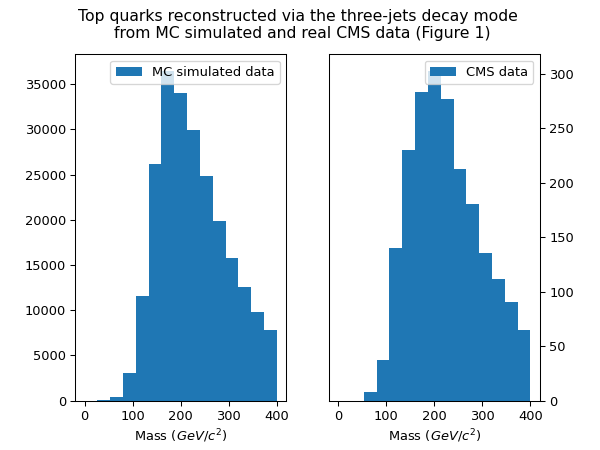

<function matplotlib.pyplot.show(block=None)>

In [15]:
fig,ax = plt.subplots(1,2)
fig.suptitle('Top quarks reconstructed via the three-jets decay mode \n from MC simulated and real CMS data (Figure 1)', fontsize=12)
ax[0].hist(jets_MC_df['mass'], range = (0,400), bins = 15,  label = 'MC simulated data')
ax[0].set_xlabel('Mass ($GeV/c^2$)')
ax[0].legend()
ax[1].hist(jets_CMS_df['mass'], range = (0,400), bins = 15,  label = 'CMS data')
ax[1].yaxis.set_ticks_position('right')
ax[1].set_xlabel('Mass ($GeV/c^2$)')
ax[1].legend()
plt.show

The histograms show that the reconstruction process was more successful using MC simulated data, since the peak occures here at about 172 $GeV/c^2$, very close to the actual mean rest mass of top quarks (172.76 $GeV/c^2$ according to Wikipedia). The peak for masses reconstructed using the CMS data occurs instead at about 195 $GeV/c^2$, farher from the actual mean value. I strongly suspect that this difference is due to the small sample size, since only 954 collisions out of the original one-hundred thousand could be retained and this in turn allowed to reconstruct a much lower number of parent particles. It is likely that, using the whole dataset, the peak would occur at the expected mass value. This could easily be done by applying the functions **get_min_particles**, **get_combinations** and **get_parent_attributes** to blocks of one-hundred thousand collisions at a time and then appending the resulting dataframes to each other. This procedure would be less time-consuming than applying the functions to the whole dataset at once.

## Final thoughts

This data analysis experience, though simple in aims and surely constrained by my currently limited background knowledge and lack of advanced analysis methods for Physics datasets, taught me a lot, both about the interesting field of high-energy particles (whose properties became now much more familiar to me) and getting confidence in applying the coding skills I previously acquired. Managing to reconstruct many of the parent particles was a reason of great satisfaction and, even in the activities where the results I got were different from those expected, I enjoyed trying to figure out ways to make hypotheses about possible alternative explanations.

I found myself particularly committed in the stage of defining my three functions: I was creating something more complex (and, hopefully, useful) and I was determined to succeed. Defining the functions was a process that I carried out in successive steps. At first, I performed the reconstruction process of $D^+$ mesons from MC simulated data by writing lengthy code limited to that task, then I had the insightful idea that I could approach this and the next reconstruction tasks by writing functions that could perform the different operations at once. Finding the optimal form for the operations each function would perform was also a discover that happened in successive stages, involving different initial drafts that led to the final code. One drawback of the functions was the long computation times they took (about ten minutes for one-hundred thousand collisions). Although this might be due to the size of the datasets, I am sure that there must be a more efficient way to define them so that results could be obtained faster. This will surely be one of the next milestones in my coding journey!